In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# Load the dataset
data = r'C:\Users\Daisy\Desktop\Herbal-Identification\Plant-Dataset\New Plant-Dataset\\'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [18]:
# Define the test dataset
test_ds = ImageFolder(os.path.join(data+'valid'), transform=transform)

In [28]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the model
model = models.resnet34(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)  # Adjust the final layer to the number of classes in your current model

# Load the state_dict from the checkpoint
state_dict = torch.load(r'C:\Users\Daisy\Desktop\Herbal-Identification\Flask\Models\herbalIdentification-resnet34.pth')

# Modify the state_dict to match the current model's fc layer
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('network.'):
        new_key = k.replace('network.', '')
        new_state_dict[new_key] = v
    else:
        new_state_dict[k] = v

# Remove the mismatched keys
new_state_dict['fc.weight'] = model.fc.weight
new_state_dict['fc.bias'] = model.fc.bias

# Load the modified state_dict into the model
model.load_state_dict(new_state_dict)
model = model.to(device)
model.eval()  # Set the model to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Label: Augmented Arjun Leaf, Predicted: Augmented Arjun Leaf, Confidence: 31.17%


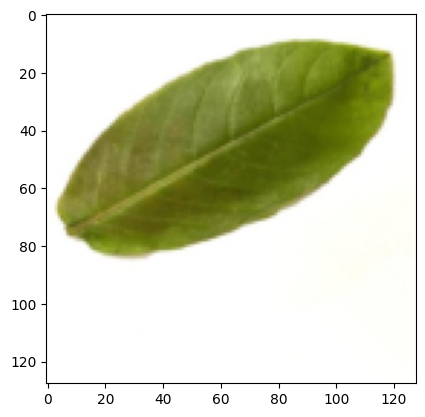

In [31]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the predict_image function
def predict_image(image, model, classes):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Check if the input image is already a tensor
        if isinstance(image, torch.Tensor):
            # Add a batch dimension
            image = image.unsqueeze(0).to(device)
        else:
            # Transform the image to match the input format of the model
            transform = transforms.Compose([
                transforms.Resize((224, 224)),  # ResNet models expect 224x224 input images
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            image = transform(image).unsqueeze(0).to(device)
        
        # Perform the forward pass
        outputs = model(image)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)
        predicted_class = classes[predicted.item()]
        
        # Calculate the confidence
        probabilities = F.softmax(outputs, dim=1)
        confidence = torch.max(probabilities).item() * 100
        
        return predicted_class, confidence

# Test with a sample image
img, label = test_ds[25]
plt.imshow(img.permute(1, 2, 0))
predicted_class, confidence = predict_image(img, model, test_ds.classes)
print(f'Label: {test_ds.classes[label]}, Predicted: {predicted_class}, Confidence: {confidence:.2f}%')


In [33]:
import utils

In [34]:
def evaluate_model(model, dataloader, classes, threshold=0.6):
    model.eval()
    correct = 0
    total = 0
    uncertain_predictions = 0
    misclassifications = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            confidences, predicted = torch.max(probabilities, 1)
            
            for confidence, prediction, label in zip(confidences, predicted, labels):
                if confidence < threshold or classes[prediction.item()] not in utils.plant_dic:
                    uncertain_predictions += 1
                elif prediction == label:
                    correct += 1
                else:
                    misclassifications += 1
                total += 1
    
    accuracy = correct / total
    uncertain_percentage = (uncertain_predictions / total) * 100
    misclassification_percentage = (misclassifications / total) * 100
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Percentage of uncertain predictions: {uncertain_percentage:.2f}%')
    print(f'Percentage of misclassifications: {misclassification_percentage:.2f}%')

# Assuming you have a DataLoader for your test dataset
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Evaluate the model
evaluate_model(model, test_dataloader, test_ds.classes)


Accuracy: 0.00
Percentage of uncertain predictions: 87.44%
Percentage of misclassifications: 12.56%
